# Week 10 Assignment: Sentiment Analysis

**Brian Roepke**  
*DATA 110*

For the given dataset perform sentiment analysis using  1) Machine Learning and 2) Lexicon-based techniques.  Refer to assigned reading (especially ch 7), supplementals, or conduct your own research.

Requirements:

1) Perform full EDA,  including key statistics and visualizations.

2) Perform required text preprocessing and feature vectorization (Eg: TF-IDF)

3) Modeling: Create ML and Lexicon-based models.

 - **Machine learning**:
     - create a new column (sent_label) for the target based on reviews.rating, where  1, 2, or 3 are labeled as 0 (negative) while 4 or greater are labeled as 1 (positive)
     - Use any appropriate ML algorithm (eg: SVM, Logistic Regression, etc...)  and create 3 different models using pipelines. 
     - Use cross-validation (StratifiedKFold for imbalanced datasets) to compare each of the models for model selection.
     - Consider the case of imbalanced dataset (Eg: significantly more positive reviews versus negative reviews). 
 - **Lexicon:**
     - Use any of the lexicons such as VADER or SentiWordNet

4) Assess performance using appropriate performance metrics. Compare performance between the two approaches.

5) For both approaches, provide visualizations of the most common words in negative and positive reviews.  These can be bar plots, word clouds, etc.

In [1]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics 
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# NLTK Imports and Downloads
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("Amazon_Consumer_Reviews.csv")

# EDA

In [3]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda


## Data Clean Up
**Change Data Types**
As needed, adjust certain datatypes to better suit analysis
 - **NULLs**: Check and fill NA values as needed.  There is one column with nulls and it's appropriate to replace them with zeros.
 - **Date Time**: Any Date time field should be converted into their appropriate types
 - **Drop Unused Fields**: Certain fields will not add to the analysis of this data and can be droped.
 - **Referer**: Create a new column for the referring domain
 - **Categories**: Certain types of fields are better suited as categories vs. objects.  These are the fields with a limited number of entries such as Category, and Manufacturer.
 - **Target**: Add a new column for the target based on reviews.rating, where  1, 2, or 3 are labeled as 0 (negative) while 4 or greater are labeled as 1 (positive).
 - **Duplicates**: Check for duplicate values

In [4]:
# check for nan/null
df.isnull().values.any()

True

In [5]:
# count of nulls
df.isnull().sum()

id                        0
dateAdded                 0
dateUpdated               0
name                      0
asins                     0
brand                     0
categories                0
primaryCategories         0
keys                      0
manufacturer              0
manufacturerNumber        0
reviews.date              0
reviews.dateSeen          0
reviews.numHelpful    12217
reviews.rating            0
reviews.sourceURLs        0
reviews.text              0
reviews.title             0
reviews.username          0
dtype: int64

In [6]:
# fill the NA values with 0
df.fillna(0, inplace=True)

In [7]:
# check for nan/null
df.isnull().values.any()

False

In [8]:
# Date Time Conversion
df['dateAdded']= pd.to_datetime(df['dateAdded'])
df['dateUpdated']= pd.to_datetime(df['dateUpdated'])
df['reviews.date']= pd.to_datetime(df['reviews.date'])

In [9]:
def get_domain(x):
    
    m = re.findall('://([\w\-\.]+)', x)
    
    try:
        return m[0]
    except:
        return "None"

In [10]:
df['domain'] = df['reviews.sourceURLs'].apply(lambda x: get_domain(x))

In [11]:
# Change to Categorical types
df["brand"] = df["brand"].astype('category')
df["primaryCategories"] = df["primaryCategories"].astype('category')
df["manufacturer"] = df["manufacturer"].astype('category')
df["reviews.username"] = df["reviews.username"].astype('category')
df["domain"] = df["domain"].astype('category')

In [12]:
# Add a length of text column before the cleaning
df['title_length'] = df.apply(lambda row: len(row['reviews.title']), axis = 1)
df['text_length'] = df.apply(lambda row: len(row['reviews.text']), axis = 1)

In [13]:
# add a column for positive or negative
df['sent_label'] = df['reviews.rating'].apply(lambda c: 0 if c < 4 else 1)

In [14]:
# Clean up some case based issues and other text issues.
df['brand'] = df['brand'].str.replace('Amazonbasics','AmazonBasics', regex=True)
df['manufacturer'] = df['manufacturer'].str.replace('Amazon.com','Amazon', regex=True)

In [15]:
df.drop(columns=['manufacturerNumber', 'keys', 'categories', 'reviews.dateSeen', 'asins'], inplace=True)

## EDA

In [16]:
df.head()

,id,dateAdded,dateUpdated,name,brand,primaryCategories,manufacturer,reviews.date,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,domain,title_length,text_length,sent_label
0,AVpgNzjwLJeJML43Kpxn,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2017-03-02 00:00:00+00:00,0.0,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,www.amazon.com,88,139,0
1,AVpgNzjwLJeJML43Kpxn,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2016-08-31 00:00:00+00:00,0.0,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,www.amazon.com,57,67,1
2,AVpgNzjwLJeJML43Kpxn,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2016-12-06 00:00:00+00:00,0.0,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,www.amazon.com,50,56,1
3,AVpgNzjwLJeJML43Kpxn,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2016-03-28 00:00:00+00:00,0.0,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,www.amazon.com,52,67,1
4,AVpgNzjwLJeJML43Kpxn,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics,Health & Beauty,AmazonBasics,2017-04-22 00:00:00+00:00,0.0,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,www.amazon.com,55,57,1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  28332 non-null  object             
 1   dateAdded           28332 non-null  datetime64[ns, UTC]
 2   dateUpdated         28332 non-null  datetime64[ns, UTC]
 3   name                28332 non-null  object             
 4   brand               28332 non-null  object             
 5   primaryCategories   28332 non-null  category           
 6   manufacturer        28332 non-null  object             
 7   reviews.date        28332 non-null  datetime64[ns, UTC]
 8   reviews.numHelpful  28332 non-null  float64            
 9   reviews.rating      28332 non-null  int64              
 10  reviews.sourceURLs  28332 non-null  object             
 11  reviews.text        28332 non-null  object             
 12  reviews.title       28332 non-nu

In [18]:
df.describe()

,reviews.numHelpful,reviews.rating,title_length,text_length,sent_label
count,28332.000000,28332.000000,28332.000000,28332.000000,28332.000000
mean,0.301073,4.514048,19.748553,137.517118,0.901631
std,7.052629,0.934957,13.860225,199.877736,0.297819
min,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,4.000000,10.000000,54.000000,1.000000
50%,0.000000,5.000000,15.000000,87.000000,1.000000
75%,0.000000,5.000000,25.000000,162.000000,1.000000
max,621.000000,5.000000,141.000000,8351.000000,1.000000


In [19]:
df.shape

(28332, 18)

In [20]:
# get categorical data
cat_data = df.select_dtypes(include=['category'])
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   primaryCategories  28332 non-null  category
 1   reviews.username   28332 non-null  category
 2   domain             28332 non-null  category
dtypes: category(3)
memory usage: 754.5 KB


In [21]:
# show counts values of each categorical variable
for colname in cat_data.columns:
    print (colname)
    print (cat_data[colname].value_counts(), '\n')

primaryCategories
Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2
Name: primaryCategories, dtype: int64 

reviews.username
ByAmazon Customer     889
Mike                   63
ByKindle Customer      45
Dave                   44
Chris                  38
                     ... 
ByRatqueen Reader       1
ByRaul Villarreal       1
ByRay J Carstensen      1
ByRay Ray               1
ztlbxx                  1
Name: reviews.username, Length: 16269, dtype: int64 

domain
reviews.bestbuy.com    16043
www.amazon.com         12144
www.ebay.com              81
redsky.target.com         43
www.amazon.co.uk          12
www.newegg.com             9
Name: domain, dtype: int64 



In [22]:
print("Before =", df.shape)
# drop duplicates
print("After =", df.drop_duplicates().shape)

Before = (28332, 18)
After = (28332, 18)


In [23]:
# Check for duplicates
len(df.drop_duplicates())

28332

**Note**: There are no duplicates

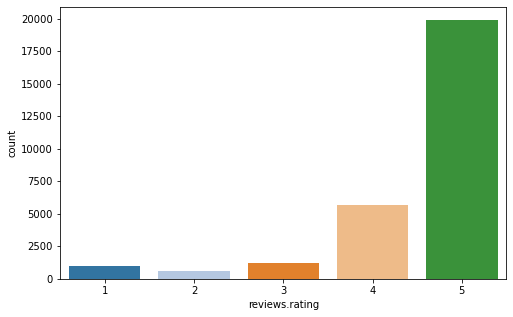

In [24]:
plt.figure(figsize=(8,5))
sns.countplot(x='reviews.rating', data=df, palette="tab20", dodge=False);

**Observations**:  The dataset is heavily imbalanced with most of the observations in the `4` and `5` star rating.

In [25]:
df_prod = df.groupby('id').mean()
df_prod

,reviews.numHelpful,reviews.rating,title_length,text_length,sent_label
id,,,,,
AV-ETMhgYSSHbkXwpNb9,3.000000,4.750000,19.500000,498.750000,1.000000
AV-EVZITKZqtpbFMSoqc,1.181818,4.590909,18.954545,247.954545,0.954545
AV2ElNnuvKc47QAVouhY,0.000000,4.000000,10.000000,31.000000,1.000000
AVpe5Q3sLJeJML43xt5X,0.000000,5.000000,9.000000,43.000000,1.000000
AVpe6nyKLJeJML43yOe2,0.000000,4.000000,94.000000,1167.000000,0.500000
...,...,...,...,...,...
AWMjXUGdHh53nbDRJ9LA,0.000000,4.333333,8.333333,131.666667,1.000000
AWP6zKOtIwln0LfXnf2p,0.857143,4.428571,17.857143,204.571429,0.857143
AWYAV-i9Iwln0LfXqrUq,0.000000,4.500000,27.000000,257.500000,1.000000


**Observations**:  There are only 65 unique products in this dataset with 28k reviews.

**Note**: Since we are not looking at individual product performance, but rather trying to predict a rating, we wont further break this down.

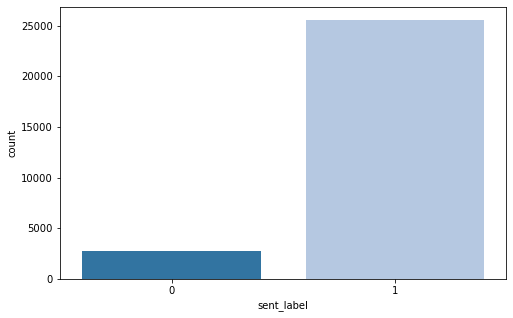

In [26]:
plt.figure(figsize=(8,5))
sns.countplot(x='sent_label', data=df, palette="tab20", dodge=False);

**Observations**:  The same view as above, but using the binary classification where `4-5` star ratings = `1` and the rest `0`.

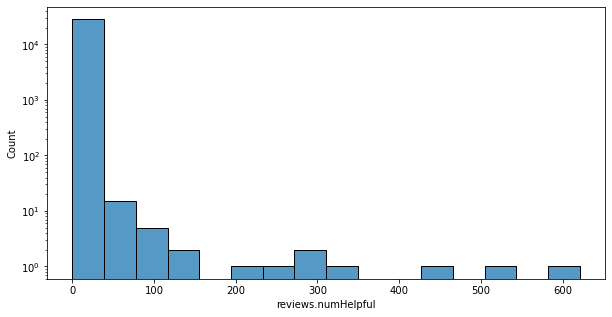

In [27]:
plt.figure(figsize=(10,5))
ax = sns.histplot(x='reviews.numHelpful', data=df, palette="tab20");
ax.set(yscale="log");

**Observations**:  There is a field that counts the number of times another user found a review helpful.  The null values were set to zero and you can see that a majority of the observations are `0` (Note that this is in log-scale on the y-axis).  There are a number of reviews that have recieved a significant amount of votes.  The max is `~600`.

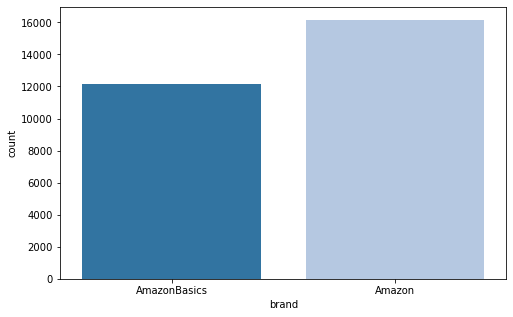

In [28]:
plt.figure(figsize=(8,5))
sns.countplot(x='brand', data=df, palette="tab20", dodge=False);

**Observations**:  The brand of all products in this dataset is Amazon.

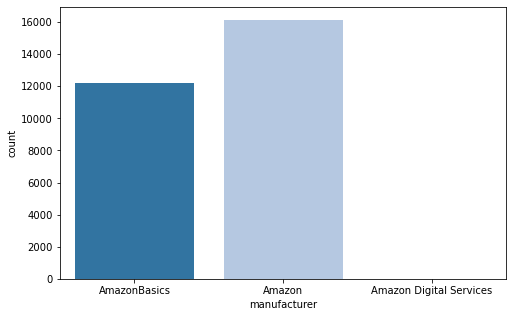

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(x='manufacturer', data=df, palette="tab20", dodge=False);

**Observations**:  There are only three Manufactures listed, all of them being Amazon with slightly different representations.  

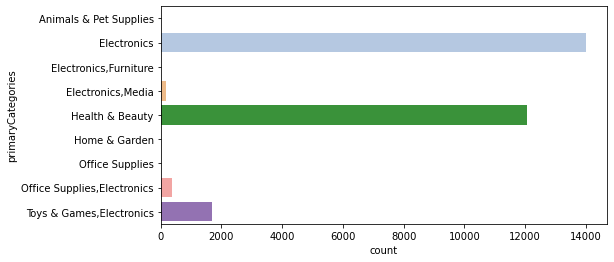

In [30]:
plt.figure(figsize=(8,4))
sns.countplot(y='primaryCategories', data=df, palette="tab20", orient='v');

**Observations**:  The top two categories for products are **Electronics** and **Health & Beauty**.  There are some in Office supplies and Toys and Games as well.

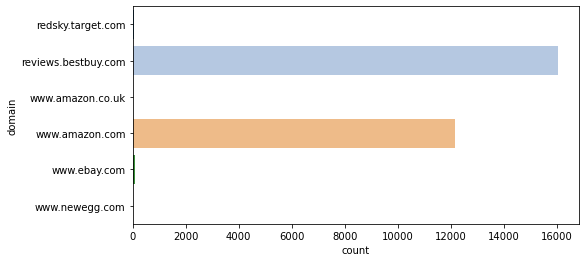

In [31]:
plt.figure(figsize=(8,4))
sns.countplot(y='domain', data=df, palette="tab20", orient='v');

**Observations**:  Very interesting.  The majority of the reviews for these Amazon products are coming from a BestBuy web site domain, the rest of them from Amazon.  There are a few other's but the majority fall into two categories.

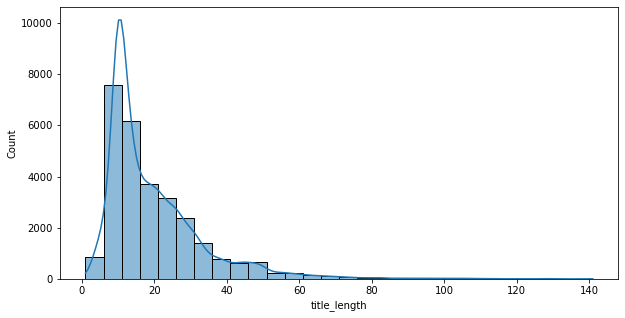

In [32]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='title_length', kde=True, palette="tab20c", binwidth=5);

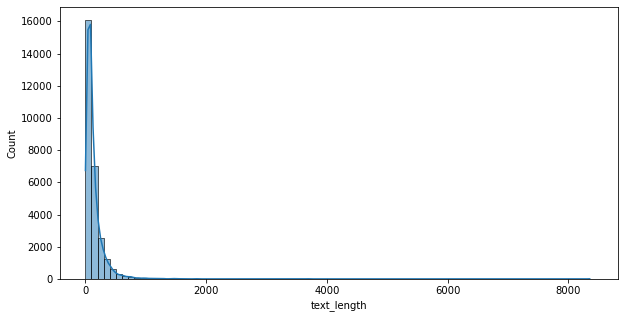

In [33]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='text_length', kde=True, palette="tab20c", binwidth=100);

**Observations**:  Most reviews are fairly short in nature. There are some extreme outliers up to `~8,000` characters.

# Preprocessing

For the initial part of the assesment we're going to use features from the NLTK library that require the text to be cleaned.  For this part we'll change to lowercase, remove stop words / punctuation and stemm the words.

This would automatically be done later for the Machine Learning processes, but it's required now.

In [34]:
df['reviews.text'][0]

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

In [35]:
def process_string(text):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    stemmer = PorterStemmer() 
    text_stemmed = [stemmer.stem(y) for y in text_filtered]
        
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [36]:
df['reviews.text'] = df['reviews.text'].apply(lambda x: process_string(x))

In [37]:
df['reviews.text'][0]

'order 3 one item bad qualiti miss backup spring put pc aluminum make batteri work '

In [38]:
# Tokenize the words
df['reviews.text.tok'] = df['reviews.text'].apply(word_tokenize)

## Positive and Negative Terms

There will be an additional analysis below, the first process will be using NLTKs Frequency Distribution (`FreqDist`) function on observations from both negative (`0`) and positive (`1`) reviews.

In [39]:
df_pos = df[df['sent_label'] == 1]
df_neg = df[df['sent_label'] == 0]

In [40]:
freq_stats_pos = []
for list in df_pos['reviews.text.tok']:
    freq_stats_pos = freq_stats_pos + list

In [41]:
fdist_pos = FreqDist(freq_stats_pos)
fdist_pos.most_common(20)

[('great', 9095),
 ('batteri', 8080),
 ('tablet', 6729),
 ('love', 6101),
 ('use', 6085),
 ('good', 5361),
 ('price', 5117),
 ('work', 4003),
 ('amazon', 3284),
 ('kindl', 2867),
 ('easi', 2837),
 ('bought', 2820),
 ('kid', 2744),
 ('one', 2742),
 ('like', 2504),
 ('buy', 2389),
 ('last', 2299),
 ('well', 2285),
 ('read', 2244),
 ('purchas', 2242)]

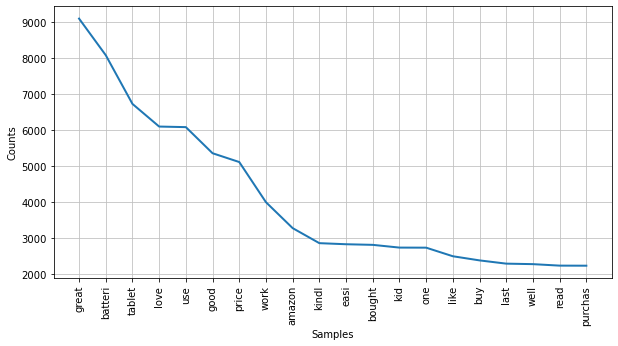

In [42]:
plt.figure(figsize=(10, 5))
fdist_pos.plot(20, cumulative=False)
plt.show()

**Observations**: Some of the top words are clearly positive words like `great`, `love`, `good`, and `like`.  Additionally there are product type words signaling that these might be strongly reccomended products/attributes.  `Battery`, `tablet`, `price`, and `kindle`.

In [43]:
freq_stats_neg = []
for list in df_neg['reviews.text.tok']:
    freq_stats_neg = freq_stats_neg + list

In [44]:
fdist_neg = FreqDist(freq_stats_neg)
fdist_neg.most_common(20)

[('batteri', 2057),
 ('use', 872),
 ('last', 855),
 ('work', 588),
 ('amazon', 580),
 ('tablet', 566),
 ('good', 495),
 ('dont', 493),
 ('long', 452),
 ('one', 436),
 ('get', 423),
 ('buy', 409),
 ('time', 371),
 ('like', 358),
 ('bought', 354),
 ('would', 335),
 ('purchas', 316),
 ('brand', 307),
 ('app', 281),
 ('price', 277)]

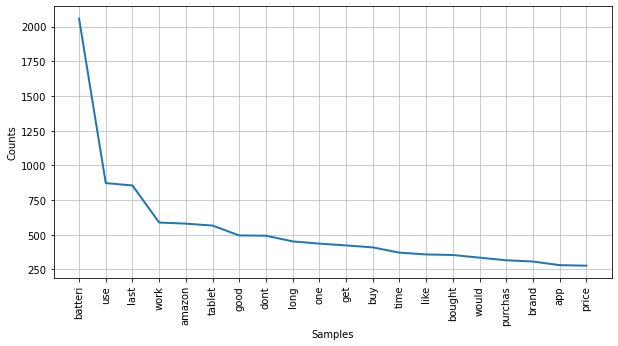

In [45]:
plt.figure(figsize=(10, 5))
fdist_neg.plot(20, cumulative=False)
plt.show()

**Observations**: The first word in the negative reviews is `battery` which also was a positive word.  That would be interesting to investigate a further.  It's also notable that battery occurs **over 2x the frequency** of the next word.  Other notable words are `dont`, `app`, and `price`.

To check for positive and negative uses of the word `batteri` in context we can use the `concordance` feature of NLTK.

In [46]:
pos_text = nltk.Text(freq_stats_pos)
pos_text.concordance('batteri', lines=10)

Displaying 10 of 8080 matches:
ice happi seem work well name brand batteri much better price batteri long last
ame brand batteri much better price batteri long last price great bought lot ba
ri long last price great bought lot batteri christma amazonbas cell good havent
good havent notic differ brand name batteri amazon basic brand lot easier purch
has arriv hous hand buy ive problam batteri order past pleas well look cheap no
st pleas well look cheap nonrecharg batteri last quit perfect noth say amazonba
t perfect noth say amazonbas aa aaa batteri done well appear good shelf life il
helf life ill buy find amazon basic batteri equal superior name brand one cant 
ar say three day mani thing need aa batteri great thank abl find amazon great p
and ship door second purchas amazon batteri work great good even better name br


In [47]:
neg_text = nltk.Text(freq_stats_neg)
neg_text.concordance('batteri', lines=10)

Displaying 10 of 2057 matches:
 backup spring put pc aluminum make batteri work hold amount high power juic li
 price first start get amazon basic batteri realli like recent purchas seem las
 camera camera expos cold temp less batteri buy bulk north hous amazon basic gr
thing like sheet beed towel opinion batteri life larg packag aaa aa size purcha
kag aaa aa size purchas lack bought batteri christma gift month decemb last lik
mb last like 2month toy need replac batteri also use doorbel need replac batter
atteri also use doorbel need replac batteri tv remot control still work batteri
batteri tv remot control still work batteri dont last long last long cheap batt
teri dont last long last long cheap batteri happi light thought fit light arriv
hought fit light arriv nice compani batteri need aa okit fault know thank got r


# Machine learning

The process for completing the Machine Learning portion of the workflow will follow the below diagram from Scikit-Learn.

The general process is the following:

1. **Pipeline Creation**: Here the overall setup for preprocessing will be captured in a sklearn pipeline, helping chain everything together and making the process repeatable.
1. **Cross Validation for Model Selection**: Here, four different models will be run across a `RepeatedStratifiedKFold` process where different "folds" or sections of the model are trained and tested against different algorithms. 
1. **Hyperparameter Optimization**:  Using a Grid Seach Cross Validation, testing each of the above four algorithms for which parameters give the best results.
1. **Model Training and Valdation**: Each model with the new parameters is then run against the training and test data for final performance evaluation.


**Note on Feature Selection:** Some cursory work on feature selection was done testing the different models, but an exhaustive slection was not performed for the sake of time / assignment.  Normally this would be done as well to determine the features that have the largest impact on model performance. 

**Workflow**  

![workflow](https://raw.githubusercontent.com/broepke/DATA110/main/Week%2010/workflow.png)

**References:**
1. Image courtesy of Scikit-Learn: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

## Cross Validation

**Model Choices:**  

We know from the EDA above that the dataset is highly imbalanced.  Rather than balancing with SMOTE or over/under sampling, we'll specifically explore classifiers that are suitable for imbalanced data.  Either with flags (`class_weight`) or by the nature of their algorithm.

 - **Support Vector Classifier**: A widely used agorithm that's simple and performs well on high dimentionality datasets.  It can be used as a regression or a classification algorithm[1].
 - **Compliment Naive Bayes**: CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets[2].
 - **LogisticRegresion:** Contains many hyper parameters for working with different datasets.  In addition to the `class_weight` parameter, it contains the abiliyt to leverage different solvers for different needs[3].  
 - **Random Forest**: Supports imbalanced data via the `class_weight` parameter[4].
 
 
1. https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47
2. https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes
3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression
4. https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

## Create Pipelines

The following columns are including in the model:

 - Primary category
 - Brand
 - Domain (where the review was placed)
 - Number of times the review was found helpful
 - Title
 - Text
 
**Note**: The ID of the product was left out because it would have a significant effect on the outcome of the prediction.  With only 65 products, it would provide a significant indicator in the model to the end rating.

In [50]:
def col_trans():
    column_trans = ColumnTransformer(
            [('primaryCategories', OneHotEncoder(dtype='int'),['primaryCategories']),
             ('brand', OneHotEncoder(dtype='int'),['brand']),
             ('domain', OneHotEncoder(dtype='int'),['domain']),
             ('numHelpful', MinMaxScaler(), ['reviews.numHelpful']),
             ('title', TfidfVectorizer(stop_words='english'), 'reviews.title'),
             ('text', TfidfVectorizer(stop_words='english'), 'reviews.text')],
            remainder='drop') 
    
    return column_trans

In [51]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = col_trans()
    
    pipeline = Pipeline([('prep',column_trans), ('clf', clf)])
     
    return pipeline

## Cross Validation for Model Selection

**Scoring Parameter**: Since there is an imbalance but we don't have a class that is more important than one or the other, the `F1` score will be used to evaluate our models.  Tht `f1` score provides a balance between precision and recall for our classifiers.

In [52]:
models = {'SVC' : SVC(class_weight='balanced', random_state=42),
         'ComplementNB' : ComplementNB(),
         'LogReg' : LogisticRegression(random_state=42, class_weight='balanced', max_iter=500),
         'RandomForest' : RandomForestClassifier(class_weight='balanced', random_state=42)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(name, ': Mean f1: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

SVC : Mean f1: 0.972 and Standard Deviation: (0.002)
ComplementNB : Mean f1: 0.955 and Standard Deviation: (0.003)
LogReg : Mean f1: 0.958 and Standard Deviation: (0.003)
RandomForest : Mean f1: 0.980 and Standard Deviation: (0.002)


The best performing model of these for is the `RandomForestClassifier`.  After all tuning and train-test validation we'll see if it still is the best performing.  However, there isn't a large difference between them, so it's worth exploring the optimization of each.

## Train Test Split

In [48]:
X = df.drop(columns=['sent_label'])
y = df['sent_label']

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [49]:
print(y_train.shape)
print(X_train.shape)

(18982,)
(18982, 18)


## Hyperparameter Optimization

The `GridSearchCV` function from Sci-Kit learn helps iterate through various parameters until the best score based on the `score` parameter, in our case `f1` for balance between `precision` and `recall`.

**Note:** Because of the long computation times for some of the parameter searches, certain variables have been reduced to smaller windows after iterating a few times.  Wider ranges were considered when running these iteratively.

In [53]:
def get_params(parameters, X, y, model):
    ''' implements a the GridSearch Cross validation for a given model and set of parameters'''
    
    clf = GridSearchCV(model, parameters, scoring='f1', n_jobs=-1)
    clf.fit(X, y)

    # extract the best alpha score
    return clf.best_params_

In [54]:
parameters = {'alpha': np.linspace(1,5,50)}
column_trans = col_trans()

clf = ComplementNB()
X_p = column_trans.fit_transform(X_train)
get_params(parameters, X_p, y_train, clf)

{'alpha': 1.8979591836734693}

In [55]:
parameters = [{'C': [4250, 4000], 
               'gamma': [.3, .25, .2], 
               'class_weight' : ['balanced']}]
column_trans = col_trans()

clf = SVC()
X_p = column_trans.fit_transform(X_train)

get_params(parameters, X_p, y_train, clf)

{'C': 4250, 'class_weight': 'balanced', 'gamma': 0.25}

In [56]:
parameters = [{'class_weight' : ['balanced'],
               'max_iter' : [1000],
               'solver' : ['newton-cg', 'lbfgs', 'sag'],
               'C' : np.linspace(50,55,5)}]
column_trans = col_trans()

clf = LogisticRegression()
X_p = column_trans.fit_transform(X_train)

get_params(parameters, X_p, y_train, clf)

{'C': 52.5,
 'class_weight': 'balanced',
 'max_iter': 1000,
 'solver': 'newton-cg'}

In [57]:
parameters = [{'class_weight' : ['balanced'],
              'criterion' : ["gini", "entropy"],
              'n_estimators' : [50, 100, 150]}]
column_trans = col_trans()
clf = RandomForestClassifier()
X_p = column_trans.fit_transform(X_train)

get_params(parameters, X_p, y_train, clf)

{'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 100}

**Note**:  Each of the above parameters will be utilized later to get the best model performance.

## Model Validation

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [59]:
def fit_and_print(pipeline):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred)

    print(metrics.classification_report(y_test, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, classes=[0,1])

              precision    recall  f1-score   support

           0      0.845     0.722     0.779       915
           1      0.970     0.986     0.978      8435

    accuracy                          0.960      9350
   macro avg      0.908     0.854     0.878      9350
weighted avg      0.958     0.960     0.958      9350

Confusion matrix, without normalization


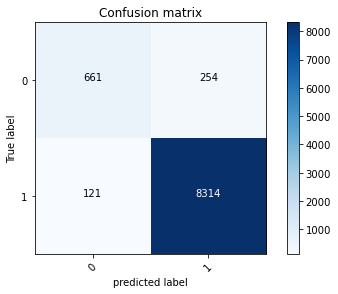

In [60]:
# {'C': 4250, 'class_weight': 'balanced', 'gamma': 0.25}
clf = SVC(C=4250, gamma=0.25, class_weight='balanced', random_state=42)
pipeline = create_pipe(clf)
fit_and_print(pipeline)

              precision    recall  f1-score   support

           0      0.776     0.415     0.541       915
           1      0.940     0.987     0.963      8435

    accuracy                          0.931      9350
   macro avg      0.858     0.701     0.752      9350
weighted avg      0.924     0.931     0.921      9350

Confusion matrix, without normalization


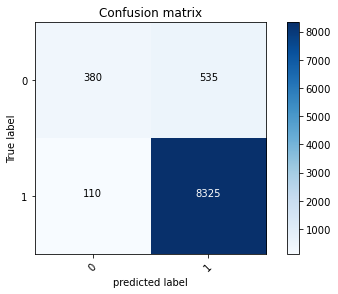

In [61]:
clf = ComplementNB(alpha=1.9)
pipeline = create_pipe(clf)
fit_and_print(pipeline)

              precision    recall  f1-score   support

           0      0.629     0.800     0.705       915
           1      0.978     0.949     0.963      8435

    accuracy                          0.934      9350
   macro avg      0.804     0.874     0.834      9350
weighted avg      0.944     0.934     0.938      9350

Confusion matrix, without normalization


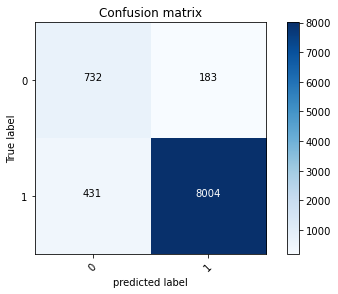

In [62]:
# {'C': 51.25, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'sag'}
clf = LogisticRegression(C=51.25, solver='newton-cg', random_state=42, class_weight='balanced', max_iter=1000)
pipeline = create_pipe(clf)
fit_and_print(pipeline)

              precision    recall  f1-score   support

           0      0.932     0.613     0.740       915
           1      0.960     0.995     0.977      8435

    accuracy                          0.958      9350
   macro avg      0.946     0.804     0.858      9350
weighted avg      0.957     0.958     0.954      9350

Confusion matrix, without normalization


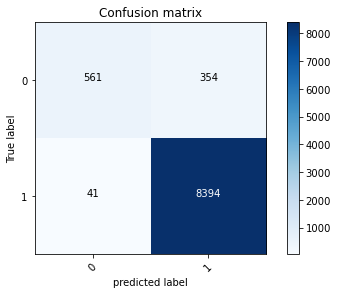

In [63]:
# {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 100}
clf = RandomForestClassifier(criterion='entropy', class_weight='balanced', n_estimators=100, random_state=42)
pipeline = create_pipe(clf)
fit_and_print(pipeline)

**Results:**  

Using `f1` as our proxy for the best model, the best `macro avg` score (unweighted average) for the four models was `0.878` for the Support Vector Classifier algorightm. After **hyperparameter tuning**, it performed slightly better than the `RandomForestClassifier` that was the original best model. 

# Sentiment Analysis

In [64]:
sid = SentimentIntensityAnalyzer()

In [65]:
# Apply the Polarity Scoring from Vader
df['vader'] = df['reviews.text'].apply(lambda review: sid.polarity_scores(review))

# Create a few extra columns to aid in the analysis
df['compound'] = df['vader'].apply(lambda score_dict: score_dict['compound'])
df['vader_score'] = df['compound'].apply(lambda c: 'pos' if c > 0 else ('neu' if c == 0 else 'neg'))
df['vader_label'] = df['compound'].apply(lambda c: 1 if c >= 0 else 0)

In [66]:
df[df.columns[-6:]].head()

,sent_label,reviews.text.tok,vader,compound,vader_score,vader_label
0,0,"[order, 3, one, item, bad, qualiti, miss, back...","{'neg': 0.298, 'neu': 0.702, 'pos': 0.0, 'comp...",-0.6249,neg,0
1,1,"[bulk, alway, less, expens, way, go, product, ...","{'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'comp...",0.3612,pos,1
2,1,"[well, duracel, price, happi]","{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",0.2732,pos,1
3,1,"[seem, work, well, name, brand, batteri, much,...","{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'comp...",0.6124,pos,1
4,1,"[batteri, long, last, price, great]","{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'comp...",0.6249,pos,1


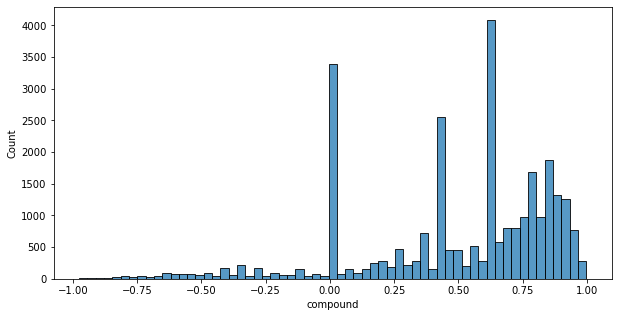

In [67]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='compound', palette="tab20c");

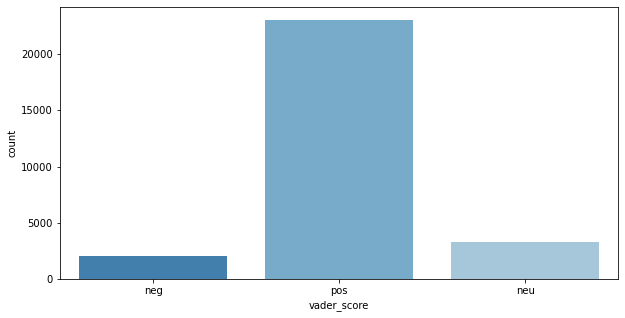

In [75]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='vader_score', palette="tab20c");

## Validating Sentiment Predictions

              precision    recall  f1-score   support

           0      0.423     0.304     0.354      2787
           1      0.926     0.955     0.940     25545

    accuracy                          0.891     28332
   macro avg      0.675     0.629     0.647     28332
weighted avg      0.877     0.891     0.883     28332


Confusion matrix, without normalization


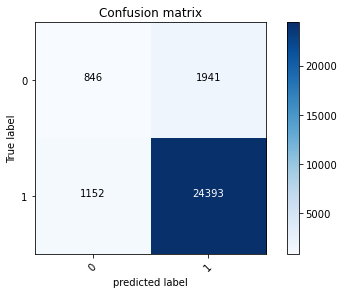

In [69]:
print(metrics.classification_report(df['sent_label'], df['vader_label'], digits=3))
print('')

cm = metrics.confusion_matrix(df['sent_label'], df['vader_label'], labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

In [70]:
df[(df['sent_label'] == 0) & (df['vader_label'] == 1)][df.columns[-6:]].head()

,sent_label,reviews.text.tok,vader,compound,vader_score,vader_label
8,0,"[hold, amount, high, power, juic, like, energ,...","{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.3612,pos,1
11,0,"[first, start, get, amazon, basic, batteri, re...","{'neg': 0.039, 'neu': 0.694, 'pos': 0.267, 'co...",0.8020,pos,1
16,0,"[dont, know, would, buy, thu, brand, seem, lik...","{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'comp...",0.3612,pos,1
17,0,"[opinion, last, anywher, near, long, duracel, ...","{'neg': 0.047, 'neu': 0.733, 'pos': 0.22, 'com...",0.8176,pos,1
19,0,"[bought, batteri, christma, gift, month, decem...","{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...",0.6597,pos,1


**Observations**:  Checking to see if some of the scores that were misclassified were borderline scores.  Looking at the scores they range from scores close to `0` to scores that are very close to `1`, meaning the user used very positive language but applied a lower star rating.

# Word Clouds

In [71]:
df_pos = df[df['vader_score'] == 'pos']
df_neg = df[df['vader_score'] == 'neg']

In [72]:
def gen_word_cloud(text, from_col, cmap='viridis'):
    
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",\
                          scale=10, colormap=cmap).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
        
    return

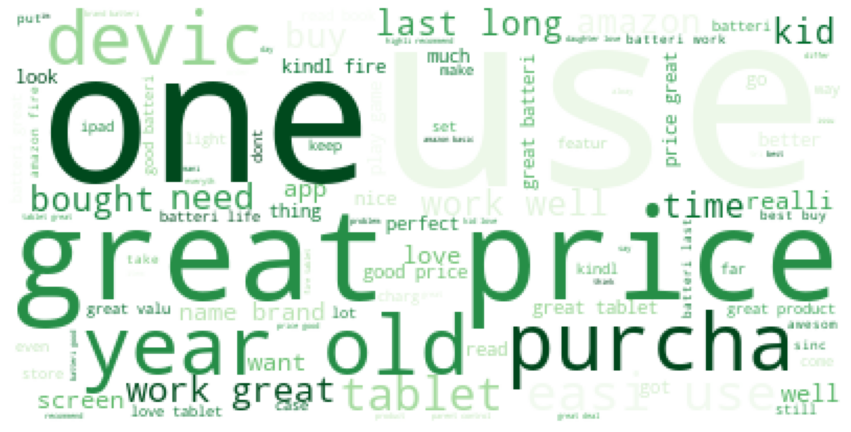

In [73]:
title = " ".join(word for word in df_pos['reviews.text'])

# Generate a word cloud image
wordcloud_pos = WordCloud(background_color="white", 
                            mode="RGBA", max_words=100, colormap='Greens').generate(title)

# create coloring from image
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_pos)
plt.axis("off")

plt.show()

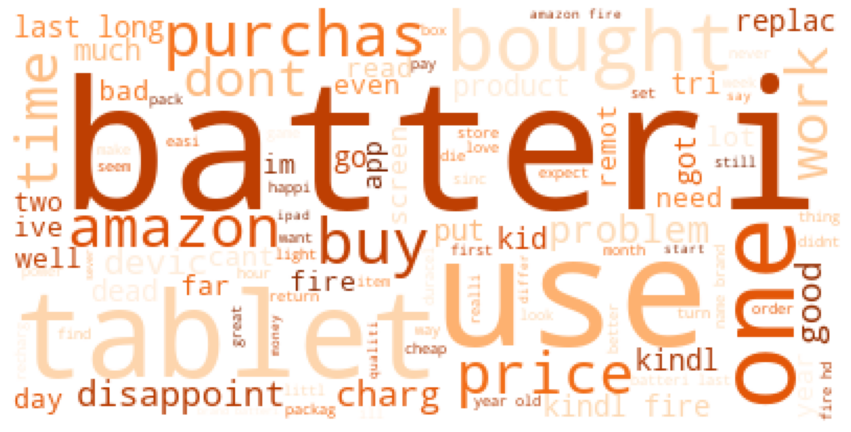

In [74]:
title = " ".join(word for word in df_neg['reviews.text'])

# Generate a word cloud image
wordcloud_neg = WordCloud(background_color="white", 
                            mode="RGBA", max_words=100, colormap='Oranges').generate(title)

# create coloring from image
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_neg)
plt.axis("off")

plt.show()

# Summary and Conclusion

 - **Performance**: The winner overall was the Machine Learning based model using the Support Vector Classifier (`SVC`).  Given we were able to use multiple features and use a supervised model, vs. the unsupervised sentiment approach, its performnace was superior.
 - **Machine Learning**: By utilitizing Hyperparameter tuning and including multiple additional features, most of the classifiers performed very well in the test.  An additional test could be done to balance the dataset and try to see if the training would improve on the `0` class.  But the algorithms used all handled imbalanced data well.
 - **Sentiment**: The method here as mentioned is totally unsupervised.  It only used the words from the text to generate a positive or negative number. This concept while not as accurate, is pretty amazing considering.  The `f1` score for the positive class (`1`) was `0.940` where the negative class (`0`) did not perform as well at `0.354`.